In [1]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [2]:
data_ = pd.read_csv("../data/FilteredData.csv")

In [3]:
def SingleAtomRemover(x):
    singleAtom = ["[Kr]","[Ne]","C","[Li]","O","[Ar]",'[Xe]']
    if x in singleAtom:
        return 1
    else: 
        return 0  

In [4]:
data = data_[["Structure","BBB+/BBB-"]]

In [5]:
data.replace({"BBB+":1,"BBB-":0},inplace=True)

In [6]:
data.rename(columns={"Structure":"SMILES","BBB+/BBB-":"LABELS"},inplace=True)

In [7]:
data["Isit"] = data["SMILES"].apply(SingleAtomRemover)

In [8]:
### Remove single element
data.drop(data[data["Isit"] == 1].index,inplace=True)

In [9]:
data.to_csv(r"raw/data.csv")

In [10]:
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
from rdkit import Chem

class BBBDataset(Dataset): ### All dataset will store File
    
    def __init__(self,root,transform = None, pre_transform=None,pre_filter=None):
        
        """
        root: where the dataset should be stored. The folder will split into raw_dir (downloaded dataset)
        and processed_dir (processed data).
        """
        super().__init__(root, transform, pre_transform, pre_filter)
    
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        dataArray = self.data[["SMILES","LABELS"]].to_numpy().squeeze()
        
        j = 0
        for i in tqdm(dataArray):
            processed_data = self.smiles2graph(*i)
            
            nodes_feats = processed_data["X"]
            label = processed_data["Y"]
            edge_feats = processed_data["E"]
            adj_mat = processed_data["A"]
            smiles = processed_data["SMILES"]
            
            
            ### create data object
            data = Data(x=nodes_feats,edge_index=adj_mat,edge_attr=edge_feats,y=label,smiles=smiles)
            
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def smiles2graph(self, smiles,label):
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            raise("Smiles not parsed by rdkit")

        adj_matrix = GetAdjacencyMatrix(mol) ### Adjacency matrix
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo,(2,-1))

        feature_array = np.zeros((mol.GetNumAtoms(),6),) ### Feature Matrix
        for idx,atom in enumerate(mol.GetAtoms()):
            feature_array[idx,0] = atom.GetAtomicNum()
            feature_array[idx,1] = atom.GetDegree()
            feature_array[idx,2] = atom.GetFormalCharge()
            feature_array[idx,3] = atom.GetHybridization()
            feature_array[idx,4] = atom.GetExplicitValence()
            feature_array[idx,5] = atom.GetMass()
           
        label_array = torch.tensor([0]) if label == 0 else torch.tensor([1]) ### label array

        all_edge_feats = []

        for bond in mol.GetBonds():
            Edge_feature = []
            # Feature 1: Bond type (as double)
            Edge_feature.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            Edge_feature.append(bond.IsInRing())
            # Append edget features to matrix (twice, per direction)
            all_edge_feats += [Edge_feature, Edge_feature]

        all_edge_feats = np.asarray(all_edge_feats)

        return {"A": torch.tensor(coo,dtype=torch.long),
               "X": torch.tensor(feature_array,dtype=torch.float32),
               "Y":torch.tensor(label_array,dtype=torch.float32),
                "E":torch.tensor(all_edge_feats,dtype=torch.float32),
                "SMILES":smiles}
    
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [11]:
dataset = BBBDataset(root=".")

Processing...
100%|█████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:04<00:00, 702.67it/s]
Done!


### Applying pytorch geometric with edge feature

In [12]:
from torch_geometric.nn import NNConv, global_add_pool

class GCNEdge(torch.nn.Module):
    
    def __init__(self,num_node_features,num_edge_features):
        
        super().__init__()
        
        ### First layer for edge convulation
        conv1_net = nn.Sequential( nn.Linear(num_edge_features,32),
                                    nn.ReLU(),
                                    nn.Linear(32,num_node_features*32),)
        
        ## second layer of edge convulation
        conv2_net = nn.Sequential(  nn.Linear(num_edge_features,32),
                                    nn.ReLU(),
                                    nn.Linear(32,32*16),)
        
        self.conv1 = NNConv(num_node_features, 32, conv1_net,)
        self.conv2 = NNConv(32,16, conv2_net)
        self.fc_1 = nn.Linear(16, 8)
        self.fc_2 = nn.Linear(8, 1)
    
    
    def forward(self,data):
        
        ## extracting data from batch
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        ## First graph conv layer
        x = F.relu(self.conv1(x,edge_index,edge_attr,))
        
        ## Second Graph conv layer
        x = F.relu(self.conv2(x,edge_index,edge_attr))
        
        ## Graph Pooling
        x = global_add_pool(x,batch)
        
        ## FeedForward Network
        x = F.relu(self.fc_1(x))
        
        ## FeedForward Network2
        x = F.sigmoid(self.fc_2(x))
        
        return x

In [255]:
from torch.utils.data import random_split

### Splitting of data
train_set, valid_set, test_set = random_split(dataset,[2500,500,330])

trainloader = DataLoader(train_set,shuffle=True,batch_size=32,)
validloader = DataLoader(valid_set, shuffle=True,batch_size=32)
testloader = DataLoader(test_set, shuffle=True,batch_size=32)

In [256]:
node_feature=6
edge_feature= 2

In [267]:
from torch.nn import BCELoss
net = GCNEdge(node_feature,edge_feature)

### initialize an optimizer with someparameters
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.0001)

### Defining loss
loss = BCELoss()

### Sending model to GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device)

In [268]:
train_loss = []
vale_loss = []

for total_epochs in range(10):
    epoch_loss = 0
    total_graphs = 0
    
    net.train() ## Training mode
    
    for batch in trainloader:
        
#       batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        
        loss_t = loss(output,batch.y.unsqueeze(1))
        loss_t.backward()
        
        epoch_loss += loss_t.item()
        total_graphs += batch.num_graphs
        optimizer.step()
        
    train_avg_loss = epoch_loss/total_graphs
    train_loss.append(train_avg_loss)
    
    val_loss = 0
    total_graphs = 0
    vale_loss = []
    
    net.eval() ## Evaluation mode
    
    for batch in validloader:
#         batch.to(device)
        output = net(batch)
        loss_e = loss(output,batch.y.unsqueeze(1))
        
        val_loss += loss_e.item()
        total_graphs += batch.num_graphs
        
    val_avg_loss = val_loss/total_graphs
    vale_loss.append(val_avg_loss)
        
    print(f"Epochs: {total_epochs} | "
           f"epoch avg. loss: {train_avg_loss:.2f} | "
            f"validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.24 | validation avg. loss: 0.17
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.09
Epochs: 2 | epoch avg. loss: 0.07 | validation avg. loss: 0.06
Epochs: 3 | epoch avg. loss: 0.05 | validation avg. loss: 0.05
Epochs: 4 | epoch avg. loss: 0.04 | validation avg. loss: 0.04
Epochs: 5 | epoch avg. loss: 0.04 | validation avg. loss: 0.04
Epochs: 6 | epoch avg. loss: 0.03 | validation avg. loss: 0.03
Epochs: 7 | epoch avg. loss: 0.03 | validation avg. loss: 0.03
Epochs: 8 | epoch avg. loss: 0.03 | validation avg. loss: 0.03
Epochs: 9 | epoch avg. loss: 0.03 | validation avg. loss: 0.03


In [265]:
train_loss

[1.2742469615936278,
 1.2475006942749023,
 1.2650004913330077,
 1.265000373840332,
 1.2475002990722657,
 1.2562502471923829,
 1.265000210571289,
 1.2475001831054688,
 1.2650001586914061,
 1.2650001419067383]

In [266]:
vale_loss

[1.2450000114440918]

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

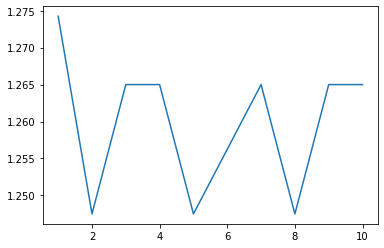

In [264]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,11)],train_loss,label="Train loss")
plt.plot([i for i in range(1,11)],vale_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()